# __This notebook will be used to investigate and implement different classification models using the iris data set__

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math



### __Loading data set__

In [39]:
IRIS_DATASET = pd.read_csv("iris data set\iris.csv")
iris_df = pd.DataFrame(IRIS_DATASET)
print(iris_df.head(5))

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


### __Visualizing data__

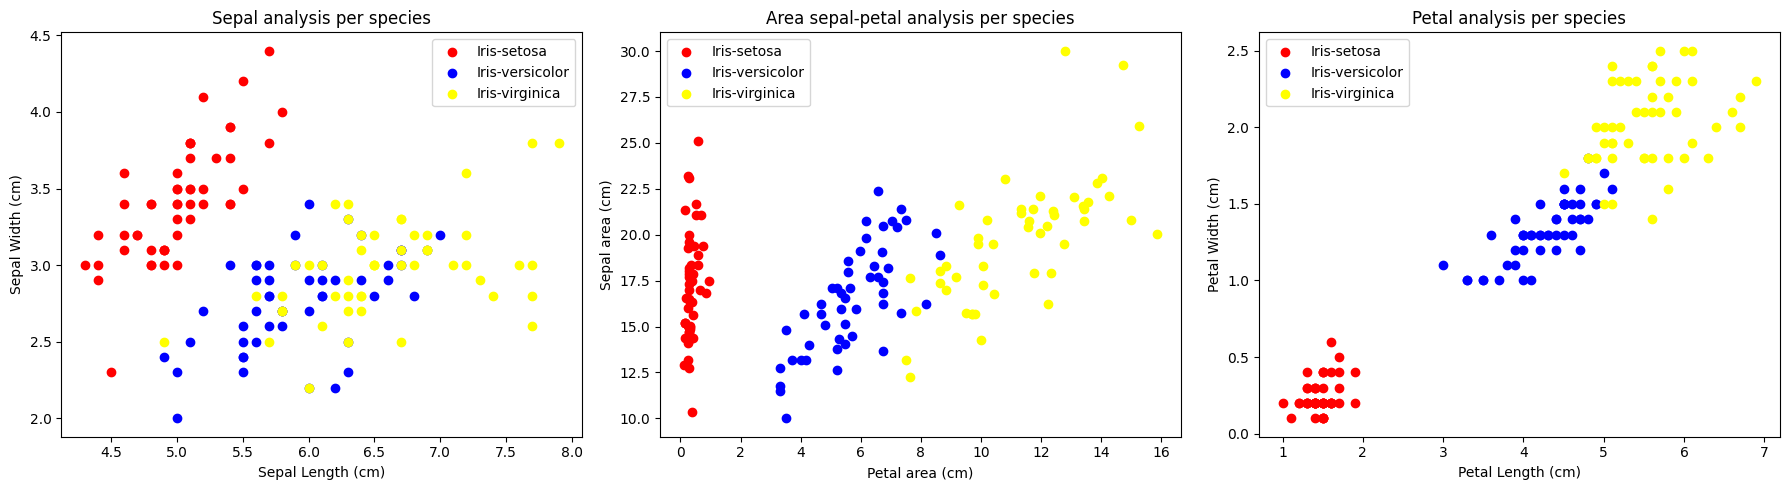

In [40]:
class IrisVisualizer: 
    def __init__(self, df, err=None):
        self.df = df
        self.error = err        # value with mismatching prediction 
        self.colors = {
            "Iris-setosa": "red",
            "Iris-versicolor": "blue",
            "Iris-virginica":"yellow"
        }
        self.species = df["Species"].unique()

    
    def plot_sepals(self, axes):
        # sepal area between species 
        for idx, row in self.df.iterrows():
            sp = row["Species"]
            color = "black" if self.error is not None and idx in self.error else self.colors[sp] 

            # compiles till we plot
            axes.scatter(
                row["SepalLengthCm"], 
                row["SepalWidthCm"], 
                color=color,
                label=sp if self.df[self.df["Species"] == sp].index[0] == idx else ""
            )

        axes.set_xlabel("Sepal Length (cm)")
        axes.set_ylabel("Sepal Width (cm)")
        axes.set_title("Sepal analysis per species")
        axes.legend()


    def plot_petals(self, axes):
        # area petal-sepal analysis
        for idx, row in self.df.iterrows():
            sp = row["Species"]
            color = "black" if self.error is not None and idx in self.error else self.colors[sp] 

            # compiles till we plot
            axes.scatter(
                row["PetalLengthCm"] * row["PetalWidthCm"], 
                row["SepalLengthCm"] * row["SepalWidthCm"],
                color=color,
                label=sp if self.df[self.df["Species"] == sp].index[0] == idx else ""
            )

        axes.set_xlabel("Petal area (cm)")
        axes.set_ylabel("Sepal area (cm)")
        axes.set_title("Area sepal-petal analysis per species")
        axes.legend()

    def plot_area(self, axes):
        # petal area between species 
        for idx, row in self.df.iterrows():
            sp = row["Species"]
            color = "black" if self.error is not None and idx in self.error else self.colors[sp] 

            # compiles till we plot
            axes.scatter(
                row["PetalLengthCm"], 
                row["PetalWidthCm"], 
                color=color,
                label=sp if self.df[self.df["Species"] == sp].index[0] == idx else ""
            )

        axes.set_xlabel("Petal Length (cm)")
        axes.set_ylabel("Petal Width (cm)")
        axes.set_title("Petal analysis per species")
        axes.legend()

def plot_predictions(df, err):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns
    viz = IrisVisualizer(df, err)
    viz.plot_sepals(axes[0])
    viz.plot_petals(axes[1])
    viz.plot_area(axes[2])
    plt.tight_layout()
    plt.show()

# Create a figure with 3 side-by-side axes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

viz = IrisVisualizer(iris_df)
viz.plot_sepals(axes[0])
viz.plot_petals(axes[1])
viz.plot_area(axes[2])

plt.tight_layout()
plt.show()

### **Baseline & Simple Models**
1. Logistic regression
    - Vanilla python

False, Count: 2
True, Count: 28
Training accuracy 0.93
inaccuracy: [[5.4 3.  4.5 1.5]
 [7.2 3.  5.8 1.6]] -> [ 84 129]
predicted: ['Iris-virginica' 'Iris-versicolor']
true value: ['Iris-versicolor' 'Iris-virginica']
[ 84  41 106 103  74  60 118 112 140 126 115  71  38  26  18  50  11  52
  27  61 129 108  43 101 114  53  99  37 132  22]


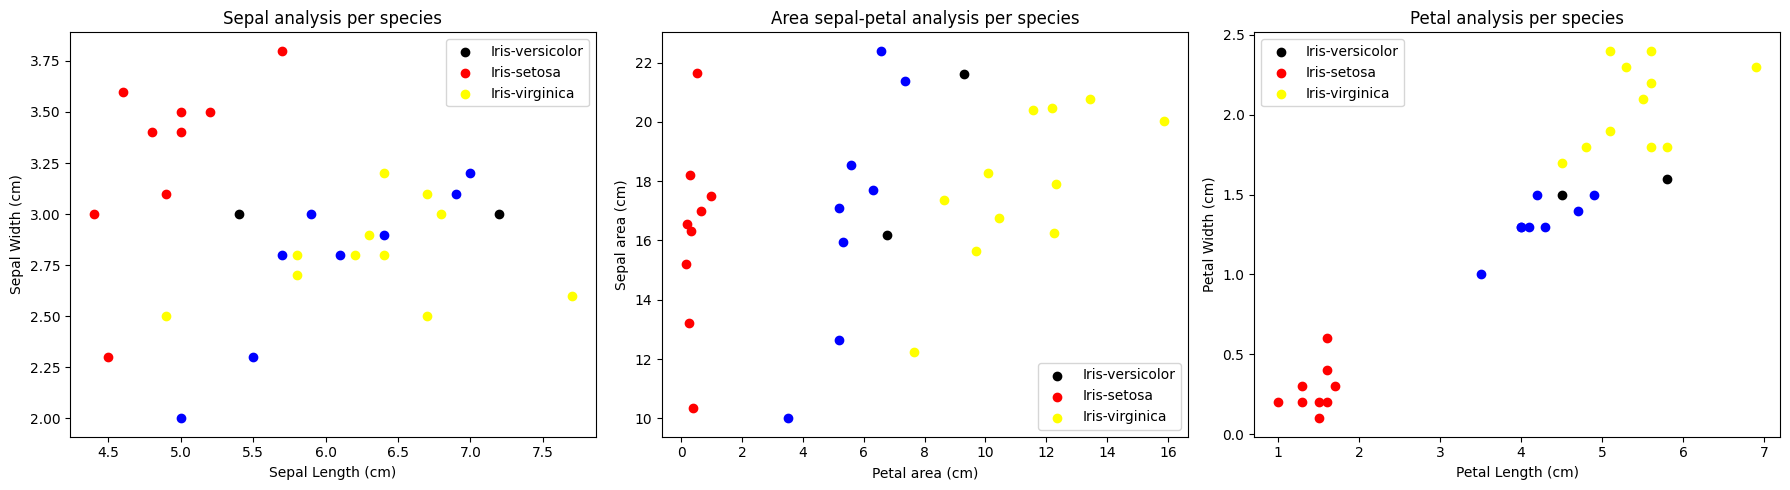

In [ ]:
def softmax(logits):
    """
    logits: shape (N, K)
    returns: probabilities, shape (N, K)
    What to do:
    - Apply the softmax equation to each row
    - Use max subtraction for numerical stability
    """
    # case 1: 1 sample -> for prediction 
    if logits.ndim == 1:
        logits = logits - np.max(logits)
        exp_logits = np.exp(logits)
        return exp_logits / np.sum(exp_logits)
    # case 2: batch (n,k) 
    else:
        logits = logits - np.max(logits, axis=1, keepdims=True)
        exp_logits = np.exp(logits)
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)


def cross_entropy_loss(probs, y_true):
    """
    probs: predicted probabilities (N, K)
    y_true: correct labels (N,) — each is class index 0..K-1
    returns: scalar loss
    What to do:
    - Pick the predicted prob for the correct class for each sample
    - Take the negative log
    - Average over N
    """
    N = len(probs)

    # grabbing true probability 
    correct_prob = probs[np.arange(N), y_true]

    # calculate the log loss of each probability 
    negative_logs = -np.log(correct_prob)

    # calculate the batch loss
    average_loss = np.mean(negative_logs)

    return average_loss
    


def forward(X, W, b):
    """
    X: input data (N, D)
    W: weights (D, K)
    b: biases (K,)
    returns: logits (N, K)
    What to do:
    - Compute XW + b
    """
    return X @ W + b  


def backward(X, probs, y_true):
    """
    X: (N, D)
    probs: (N, K)
    y_true: (N,)
    returns: gradients dW, db
    What to do:
    - Convert y_true into one-hot
    - Compute derivative of loss w.r.t. logits
    - Get dW and db
    """
    N = np.shape(X)[0]
    K = np.shape(probs)[1]
    encoded_y_true = np.zeros((N, K))
    encoded_y_true[np.arange(N), y_true] = 1

    dJ_dW = (1/N) * np.matmul(np.transpose(X), probs - encoded_y_true )
    dL_db = (1/N) * np.sum(probs - encoded_y_true, axis=0)

    return  dJ_dW, dL_db



def train(X, Y, lr=0.1, epochs=200, train_batch=True):
    """
    Train loop:
    - Initialize W, b
    - For each epoch:
        - Forward pass → logits → softmax
        - Compute loss
        - Backward pass → gradients
        - Update W, b with gradient descent
    - Return trained W, b
    """

    # initialize weight and biases
    w = np.zeros((np.shape(X)[1], 3)) # 1x4 feature * 4 (len of x) x 3 (output)
    b = np.zeros(3,) 

    for epoch in range(epochs): 
        logits =  forward(X, w, b)      # returns z
        probability = softmax(logits)   # computes the probability 

        loss = cross_entropy_loss(probability, Y)
        dw , db = backward(X, probability, Y)
        
        w -= dw * lr
        b -= db * lr

        if epoch % 10 == 0:
            pass
            # print(f"i:{epoch} current loss: {loss:.2f}")
    return w, b 

def clean_data():
    # extracting paramters 
    # Drop the label column (Species)
    X = iris_df.drop(columns=["Species", "Id"]).values

    # Grab the label column separately
    y = iris_df["Species"]

    # Process category in numerical format (easy way -> y = iris_df["Species"].astype('category').cat.codes.values)
    label = {
        "Iris-setosa": 0,
        "Iris-versicolor": 1,
        "Iris-virginica":2
    }

    Y = y.map(label).values

    # seperate testing and training data 
    N = len(iris_df)
    indices = np.arange(N)
    np.random.shuffle(indices)
    
    split = int(N * .8)
    
    train_idx = indices[:split]
    test_idx = indices[split:]

    Xtrain = X[train_idx]
    Xtest = X[test_idx]
    Ytrain = Y[train_idx]
    Ytest = Y[test_idx]

    return Xtrain, Xtest, Ytrain, Ytest, train_idx, test_idx



def predict(X,W,b):
    logits = forward(X, W, b)
    probs = softmax(logits)
    return np.argmax(probs, axis=1)



def evaluate(X,Y,W,b, df, test_idx):
    predicted_value = predict(X,W,b)
    matches = predicted_value == Y

    species =np.array(["Iris-setosa",
        "Iris-versicolor",
        "Iris-virginica"])

    unique_elements, counts = np.unique(matches, return_counts=True)

    for element, count in zip(unique_elements, counts):
        print(f"{element}, Count: {count}")
    
    wrong_label = np.where(matches == False)[0]
    df_idx = test_idx[wrong_label]
    print(f"Training accuracy {np.mean(matches):.2f}")
    print(f"inaccuracy: {X[wrong_label]} -> {df_idx}\npredicted: {species[predicted_value[wrong_label]]}\ntrue value: {species[Y[wrong_label]]}")
    df = df.iloc[test_idx]
    plot_predictions(df, df_idx)

    

Xtrain, Xtest, Ytrain, Ytest, train_idx, test_idx  = clean_data()

# get weight and bias for prediction 
w, b = train(Xtrain, Ytrain)
evaluate(Xtest, Ytest,w,b, iris_df, test_idx)

### __KNN prediction__
#### Vanilla python 